## Imports

In [116]:
#Library imports
import re
import os
import shutil
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:22: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

## Organizing and splitting the data

### Kuzushiji Kanji

In [166]:
orig_kuzushiji_kanji_dir = 'data/kuzushiji49/kkanji2'
split_kanji_dir = "data/kuzushiji49/kanji_transfer"

In [216]:
directory_sizes = [[directory, len(os.listdir(f"{orig_kuzushiji_kanji_dir}/{directory}"))] for directory in os.listdir(orig_kuzushiji_kanji_dir)]
directory_counts = pd.DataFrame(directory_sizes, columns=["folder", "count"])
directory_counts["char"] = directory_counts["folder"].map(lambda x: chr(int(x[2:], 16)))
directory_counts

,folder,count,char
0,U+5375,197,卵
1,U+5BC6,30,密
2,U+85A6,6,薦
3,U+8DE1,109,跡
4,U+7409,2,琉
...,...,...,...
3827,U+5B63,37,季
3828,U+75B3,2,疳
3829,U+9322,9,錢
3830,U+675C,12,杜


In [205]:
sizes = [[i, directory_counts[directory_counts["count"] >= i]["count"].size, directory_counts[directory_counts["count"] >= i]["count"].sum()] for i in np.arange(1, 1769)]
sizes = pd.DataFrame(sizes, columns = ["min", "classes", "total_chars"]).set_index("min")

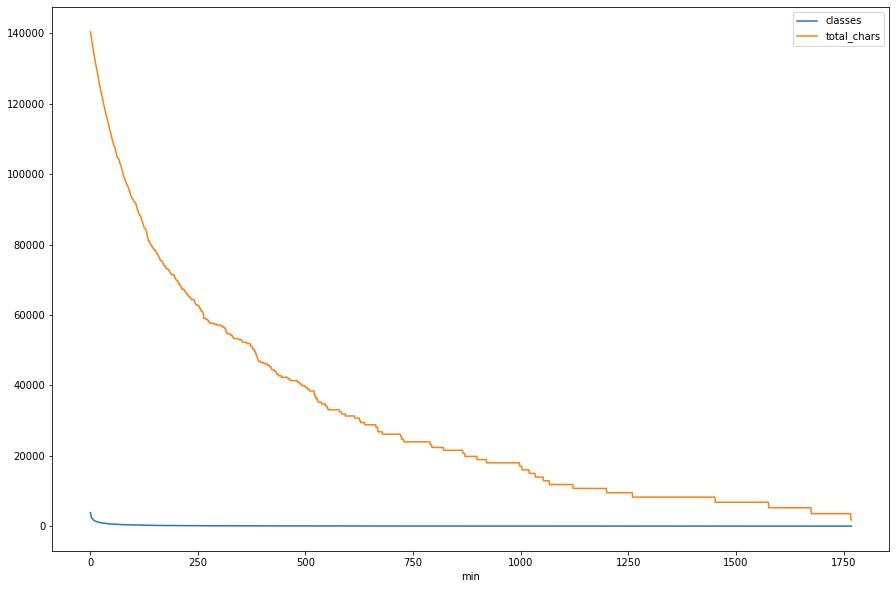

In [206]:
sizes.plot(figsize=(15,10))

By filtering out the categories with less than 10 observations, 1566 classes remain.

In [208]:
sizes.loc[10]

classes          1566
total_chars    133480
Name: 10, dtype: int64

In [167]:
kanji_train = os.path.join(split_kanji_dir, "train")
kanji_val = os.path.join(split_kanji_dir, "val")
kanji_test = os.path.join(split_kanji_dir, "test")

In [330]:
os.makedirs(kanji_train)
os.makedirs(kanji_val)
os.makedirs(kanji_test)

In [331]:
kanji_dir_list = directory_counts[directory_counts["count"] >= 10]["folder"].to_numpy().tolist()

In [ ]:
for directory in kanji_dir_list:
    paths = image_path_extractor(directory, orig_kuzushiji_kanji_dir, random_seed=SEED)
    train, val, test = image_path_list_train_test_split(paths, .7, .1)
    
    image_path_copier(train, orig_kuzushiji_kanji_dir, kanji_train, directory)
    image_path_copier(val, orig_kuzushiji_kanji_dir, kanji_val, directory)
    image_path_copier(test, orig_kuzushiji_kanji_dir, kanji_test, directory)

The remaining kanji characters with less than 10 observations might be useful in their aggregate form as a class of their own.

In [333]:
sizes.loc[1]["total_chars"]-sizes.loc[10]["total_chars"]

6944

In [334]:
other_dirs = directory_counts[directory_counts["count"] < 10]["folder"].to_numpy().tolist()
other_paths = image_path_extractor(other_dirs, orig_kuzushiji_kanji_dir, random_seed=SEED)

train, val, test = image_path_list_train_test_split(other_paths, .7, .1)

#Copies the files to their new subdirectories.
image_path_copier(train, orig_kuzushiji_kanji_dir, kanji_train, "other")
image_path_copier(val, orig_kuzushiji_kanji_dir, kanji_val, "other")
image_path_copier(test, orig_kuzushiji_kanji_dir, kanji_test, "other")

4860 files copied to data/kuzushiji49/kanji_transfer/train/other
1389 files copied to data/kuzushiji49/kanji_transfer/val/other
695 files copied to data/kuzushiji49/kanji_transfer/test/other


### EMNIST

In [162]:
emnist_train_data = parse_emnist("data/emnist/emnist-bymerge-train-images-idx3-ubyte.gz")
emnist_train_labels = parse_emnist("data/emnist/emnist-bymerge-train-labels-idx1-ubyte.gz", offset=8, isimg=False)
emnist_test_data = parse_emnist("data/emnist/emnist-bymerge-test-images-idx3-ubyte.gz")
emnist_test_labels = parse_emnist("data/emnist/emnist-bymerge-test-labels-idx1-ubyte.gz", offset=8, isimg=False)

In [163]:
emnist_train_data = pad_raster_edges(emnist_train_data, 2, 2)
emnist_test_data = pad_raster_edges(emnist_test_data, 2, 2)

In [164]:
full_value_counts(pd.DataFrame(emnist_train_labels), 0)

There are 47 unique values with 0 nan values making up 0.0%
38304-1 --5.49%
36020-7 --5.16%
35285-3 --5.06%
34618-0 --4.96%
34307-2 --4.92%
34150-6 --4.89%
33924-8 --4.86%
33882-9 --4.85%
33656-4 --4.82%
31280-5 --4.48%
27664-24 --3.96%
24657-39 --3.53%
23509-28 --3.37%
20381-21 --2.92%
18248-46 --2.61%
15388-30 --2.20%
14733-18 --2.11%
14060-45 --2.01%
12963-12 --1.86%
11612-22 --1.66%
11444-43 --1.64%
10748-25 --1.54%
10152-38 --1.45%
10009-36 --1.43%
9766-29 --1.40%
9098-15 --1.30%
8682-42 --1.24%
8237-23 --1.18%
7588-31 --1.09%
7403-32 --1.06%
7092-34 --1.02%
6411-10 --0.92%
5689-19 --0.82%
5598-33 --0.80%
5416-35 --0.78%
5080-37 --0.73%
5047-27 --0.72%
4998-20 --0.72%
4925-14 --0.71%
4606-13 --0.66%
3874-11 --0.56%
3693-41 --0.53%
3097-17 --0.44%
2966-44 --0.42%
2603-26 --0.37%
2535-40 --0.36%
2534-16 --0.36%


The amount of observations in this dataset vastly exceed the observations in the kanji set. To prevent these observations from overwhelming the rest of the data, I've downsampled to the lowest value since, 2534 observations is still significant in comparison.

In [165]:
#My resample function requires each observation to be a vector, so the images are reshaped before resampling
emnist_train_data, emnist_train_labels = preprocess_raster_resampling(images_to_1d(emnist_train_data), emnist_train_labels, "downsample", random_state=SEED)
emnist_test_data, emnist_test_labels = preprocess_raster_resampling(images_to_1d(emnist_test_data), emnist_test_labels, "downsample", random_state=SEED)

#Creates a validation set
emnist_train_X, emnist_val_X, emnist_train_y, emnist_val_y = train_test_split(emnist_train_data, emnist_train_labels, test_size=.2, random_state=SEED)

# Restoring the original shape while explicitly adding it's color channel.
emnist_train_X = images_to_1d(emnist_train_X, 32, 32, 1, inverse=True)
emnist_val_X = images_to_1d(emnist_val_X, 32, 32, 1, inverse=True)
emnist_test_data = images_to_1d(emnist_test_data, 32, 32, 1, inverse=True)

performing downsample
performing downsample


In [180]:
emist_pref = "emnist_"
export_numpy_array_to_images(emnist_train_X, emnist_train_y, kanji_train, emist_pref)
export_numpy_array_to_images(emnist_val_X, emnist_val_y, kanji_val, emist_pref)
export_numpy_array_to_images(emnist_test_data, emnist_test_labels, kanji_test, emist_pref)

### Obsolete Kana


Finally, it might help to add in those obsolete observations from the hiragana set to build a more robust base for transfer learning. The proprocessing at this stage will be with a lighter touch since it will be heppening after the image sets are exported and reimported with the rest of the images.

In [200]:
# Importing the datasets
obs_kana_train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
obs_kana_train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
obs_kana_test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
obs_kana_test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']

# Eliminating the classes that are already used in the main model.
obsolete_mask_train = (obs_kana_train_labels == 44) | (obs_kana_train_labels == 45) | (obs_kana_train_labels == 48)
obsolete_mask_test = (obs_kana_test_labels == 44) | (obs_kana_test_labels == 45) | (obs_kana_test_labels == 48)
obs_kana_train_data, obs_kana_train_labels = obs_kana_train_data[obsolete_mask_train], obs_kana_train_labels[obsolete_mask_train]
obs_kana_test_data, obs_kana_test_labels = obs_kana_test_data[obsolete_mask_test], obs_kana_test_labels[obsolete_mask_test]

# Match kanji folder structure by replacing the key with the unicode value.
to_replace, unicode_sym = 44, "U+3090"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

to_replace, unicode_sym = "45", "U+3091"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

to_replace, unicode_sym = "48", "U+309E"
obs_kana_train_labels, obs_kana_test_labels = np.where(obs_kana_train_labels == to_replace, unicode_sym, obs_kana_train_labels), np.where(obs_kana_test_labels == to_replace, unicode_sym, obs_kana_test_labels)

#Adding the padding to make all images 32x32 and allow for edge buffer during transformations.
obs_kana_train_data = pad_raster_edges(obs_kana_train_data, 2, 2)
obs_kana_test_data = pad_raster_edges(obs_kana_test_data, 2, 2)

#Creates a validation set
obs_kana_train_X, obs_kana_val_X, obs_kana_train_y, obs_kana_val_y = train_test_split(obs_kana_train_data, obs_kana_train_labels, test_size=.2, random_state=SEED)

# Restoring the original shape while explicitly adding it's color channel.
obs_kana_train_X = images_to_1d(obs_kana_train_X, 32, 32, 1, inverse=True)
obs_kana_val_X = images_to_1d(obs_kana_val_X, 32, 32, 1, inverse=True)
obs_kana_test_data = images_to_1d(obs_kana_test_data, 32, 32, 1, inverse=True)

In [203]:
export_numpy_array_to_images(obs_kana_train_X, obs_kana_train_y, kanji_train)
export_numpy_array_to_images(obs_kana_val_X, obs_kana_val_y, kanji_val)
export_numpy_array_to_images(obs_kana_test_data, obs_kana_test_labels, kanji_test)

## Preprossess

In [204]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [205]:
X_train_generator = train_generator.flow_from_directory(kanji_train, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(kanji_val, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(kanji_test, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 14756)

Found 196357 images belonging to 1617 classes.
Found 52741 images belonging to 1617 classes.
Found 34967 images belonging to 1617 classes.


In [377]:
X_dummy_train_generator = train_generator.flow_from_directory(kanji_train, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 1567)
X_dummy_test_generator = test_generator.flow_from_directory(kanji_test, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 1567)

dummmy_train, dummy_test = next(X_dummy_train_generator), next(X_dummy_test_generator)

dummy_X_train, dummy_y_train = dummmy_train[0], np.argmax(dummmy_train[1], axis=1)
dummy_X_test, dummy_y_test = dummy_test[0], np.argmax(dummy_test[1], axis=1)

baseline_predictor = DummyClassifier(strategy="stratified", random_state=SEED)
baseline_predictor.fit(dummy_X_train, dummy_y_train)
y_hat = baseline_predictor.predict(dummy_X_test)
image_class_accuracy_scores(dummy_y_test, y_hat)

Found 97614 images belonging to 1567 classes.
Found 14756 images belonging to 1567 classes.
Accuracy: 0.004467134652201659
Balanced Accuracy: 0.0005860734827007006


(0.004467134652201659, 0.0005860734827007006)

## Model1

In [209]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(X_train_generator.classes), 
            X_train_generator.classes)

In [379]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64 ,64,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(1000, "relu"),
          Dense(1567, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelk1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)      

In [380]:
backupsk1 = ModelCheckpoint("model_backups/modelk1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

resultsk1 = modelk1.fit(X_train_generator, epochs=200, steps_per_epoch=3050, validation_data=X_val_generator, validation_steps=876, class_weight=class_weights, callbacks=[backupsk1, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3050 steps, validate for 876 steps
Epoch 1/200
3050/3050 [==============================] - 58s 19ms/step - loss: 4.0039 - accuracy: 0.3522 - val_loss: 2.0887 - val_accuracy: 0.6140
Epoch 2/200
3050/3050 [==============================] - 58s 19ms/step - loss: 1.8978 - accuracy: 0.6119 - val_loss: 1.1777 - val_accuracy: 0.7444
Epoch 3/200
3050/3050 [==============================] - 58s 19ms/step - loss: 1.1889 - accuracy: 0.7251 - val_loss: 0.8559 - val_accuracy: 0.8012
Epoch 4/200
3050/3050 [==============================] - 58s 19ms/step - loss: 0.8604 - accuracy: 0.7876 - val_loss: 0.7286 - val_accuracy: 0.8283
Epoch 5/200
3050/3050 [==============================] - 58s 19ms/step - loss: 0.6664 - accuracy: 0.8306 - val_loss: 0.6376 - val_accuracy: 0.8526
Epoch 6/200
3050/3050 [==============================] - 58s 19ms/step - loss: 0.5309 - accuracy: 0.8596 - val_loss: 0.6397 - val_accuracy: 0.8571
Epoch 7/200
3050/3050 [

In [381]:
test_batch = next(X_test_generator)
image_class_evaluation(modelk1, test_batch[0], test_batch[1])

Accuracy: 0.8896719978313906
Balanced Accuracy: 0.7921170669058342


(0.8896719978313906, 0.7921170669058342)

## Model2

In [206]:
X_train_generator_sm = train_generator.flow_from_directory(kanji_train, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator_sm = test_generator.flow_from_directory(kanji_val, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator_sm = test_generator.flow_from_directory(kanji_test, target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)

Found 196357 images belonging to 1617 classes.
Found 52741 images belonging to 1617 classes.
Found 34967 images belonging to 1617 classes.


In [383]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(1000, "relu"),
          Dense(1567, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelk2 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)        

In [384]:
backupsk2 = ModelCheckpoint("model_backups/kanji/modelk2-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

resultsk2 = modelk2.fit(X_train_generator_sm, epochs=200, steps_per_epoch=3050, validation_data=X_val_generator_sm, validation_steps=876, class_weight=class_weights, callbacks=[backupsk2, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3050 steps, validate for 876 steps
Epoch 1/200
3050/3050 [==============================] - 47s 15ms/step - loss: 4.4977 - accuracy: 0.2746 - val_loss: 2.6937 - val_accuracy: 0.5017
Epoch 2/200
3050/3050 [==============================] - 47s 15ms/step - loss: 2.4054 - accuracy: 0.5219 - val_loss: 1.6018 - val_accuracy: 0.6564
Epoch 3/200
3050/3050 [==============================] - 47s 15ms/step - loss: 1.6068 - accuracy: 0.6384 - val_loss: 1.2375 - val_accuracy: 0.7182
Epoch 4/200
3050/3050 [==============================] - 46s 15ms/step - loss: 1.2122 - accuracy: 0.7142 - val_loss: 0.9789 - val_accuracy: 0.7751
Epoch 5/200
3050/3050 [==============================] - 47s 15ms/step - loss: 0.9626 - accuracy: 0.7600 - val_loss: 0.8578 - val_accuracy: 0.8037
Epoch 6/200
3050/3050 [==============================] - 47s 15ms/step - loss: 0.7943 - accuracy: 0.7969 - val_loss: 0.7851 - val_accuracy: 0.8166
Epoch 7/200
3050/3050 [

In [386]:
test_batch = next(X_test_generator_sm)
image_class_evaluation(modelk2, test_batch[0], test_batch[1])

Accuracy: 0.84375
Balanced Accuracy: 0.8981481481481481


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.84375, 0.8981481481481481)

In [210]:
X_dummy_train_generator = train_generator.flow_from_directory(kanji_train, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 1567)
X_dummy_test_generator = test_generator.flow_from_directory(kanji_test, target_size=(64, 64), color_mode='grayscale', seed=SEED, batch_size = 1567)

dummmy_train, dummy_test = next(X_dummy_train_generator), next(X_dummy_test_generator)

dummy_X_train, dummy_y_train = dummmy_train[0], np.argmax(dummmy_train[1], axis=1)
dummy_X_test, dummy_y_test = dummy_test[0], np.argmax(dummy_test[1], axis=1)

baseline_predictor = DummyClassifier(strategy="stratified", random_state=SEED)
baseline_predictor.fit(dummy_X_train, dummy_y_train)
y_hat = baseline_predictor.predict(dummy_X_test)
image_class_accuracy_scores(dummy_y_test, y_hat)

Found 196357 images belonging to 1617 classes.
Found 34967 images belonging to 1617 classes.
Accuracy: 0.012125079770261647
Balanced Accuracy: 0.0031651784908406804


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(0.012125079770261647, 0.0031651784908406804)

In [211]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(1000, "relu"),
          Dense(1617, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
modelk3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [212]:
backupsk3 = ModelCheckpoint("model_backups/kanji/modelk3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

resultsk3 = modelk3.fit(X_train_generator_sm, epochs=200, steps_per_epoch=6136, validation_data=X_val_generator_sm, validation_steps=1648, class_weight=class_weights, callbacks=[backupsk3, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6136 steps, validate for 1648 steps
Epoch 1/200
6133/6136 [============================>.] - ETA: 0s - loss: 2.8273 - accuracy: 0.4815WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_backups/kanji/modelk3-01/assets
6136/6136 [==============================] - 99s 16ms/step - loss: 2.8270 - accuracy: 0.4815 - val_loss: 1.8406 - val_accuracy: 0.6243
Epoch 2/200
6136/6136 [==============================] - 88s 14ms/step - loss: 1.5112 - accuracy: 0.6703 - val_loss: 1.1645 - val_accuracy: 0.7308
Epoch 3/200
6136/6136 [==============================] - 89s 14ms/step - loss: 1.0453 - a

In [214]:
test_batch = next(X_test_generator_sm)
image_class_evaluation(modelk3, test_batch[0], test_batch[1])

Accuracy: 0.84375
Balanced Accuracy: 0.8392857142857143


(0.84375, 0.8392857142857143)